# Build weather radar zone suitablity layers for GRIDCERF


The following code was used to build the weather radar zone suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.5281/zenodo.6601789.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  Weather Radar Stations
- **Description from Source**: These data represent Next-Generation Radar (NEXRAD) and Terminal Doppler Weather Radar (TDWR) weather radar stations within the US. The NEXRAD radar stations are maintained and operated by the National Oceanic and Atmospheric Administration. The TDWR radar stations are maintained and operated by the Federal Aviation Administration.
- **Source URL**:  https://marinecadastre-noaa.hub.arcgis.com/datasets/noaa::weather-radar-stations/about
- **Date Accessed**:  9/25/23
- **Citation**
> Office for Coastal Management, 2023: Weather Radar Stations, https://www.fisheries.noaa.gov/inport/item/48940.
- **Application**: For the GRIDCERF exclusion layer information, the location of the radars + a 5 mile buffer is used. This is intended to represent the "no build zone" found in the Weather Radar Impact Zones analysis shown in https://www.fisheries.noaa.gov/inport/item/57239 and https://www.arcgis.com/home/webmap/viewer.html?url=https://coast.noaa.gov/arcgis/rest/services/Hosted/WeatherRadarImpactZones/FeatureServer&extent=-100,40&level=4. The detailed exclusion information around each radar station is not publicly available.

### 1.3 Import modules


In [3]:
import os

import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features

## 2. Configuration


In [12]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded airport data
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific",  'weather_radar_stations' )

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# shapefile location for the source airports
radar_shpfile = os.path.join(source_dir,'Weather_Radar_Stations',  "Weather_Radar_Stations.shp")

# output rasters
output_radar_file = os.path.join(technology_specific_dir, "gridcerf_noaa_radar_stations_5mi_buffer.tif")

# factor for converting a mile to meter
mi_to_meter = 1609.34

# crs for converting projections
crs = 'ESRI:102003'


## 4. Generate suitability rasters

### 4.1 Functions to build suitability

In [11]:
def vector_to_raster(template_raster, land_mask_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask_file = rasterio.open(land_mask_raster)
        land_mask = land_mask_file.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 4.2 Generate suitability

In [6]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

<Axes: >

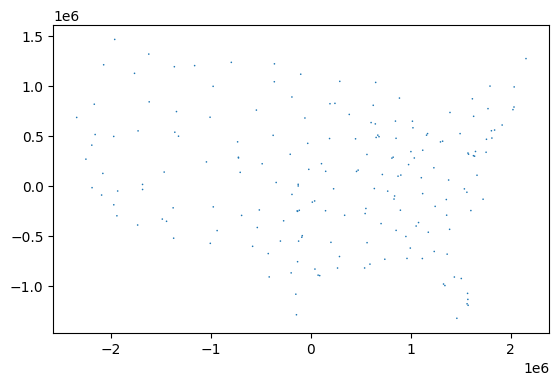

In [9]:
# read in shapefile and project to our GRIDCERF projection
gdf = gpd.read_file(radar_shpfile).to_crs(crs=crs)

# only keep areas within our GRIDCERF boundary
gdf = gpd.clip(gdf, bdf)

# add field to use for rasterization
gdf["value"] = 1

# generate areas buffered by 5 miles
gdf["geometry"] = gdf.buffer(5 * mi_to_meter)

gdf.plot()

In [13]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=land_mask_raster,
                 gdf=gdf, 
                 value_field="value",
                 output_raster=output_radar_file)